## Searching for GWs using a PTA
This notebook explores at how to search for GWs using a PTA and an Unscented Kalman filter.


It is entirely concerned with the problem of **detection** (_"Is there evidence of a GW in my data?"_) rather than **parameter estimation** (_"What is the frequency of the GW?"_)


---

## 0. Setup

First lets quickly setup the notebook and make the source code accessible

In [316]:
%load_ext autoreload
%autoreload 2

import sys
# Hacky way to add higher directory to python modules path.
# Means that I dont have to make src/ a proper python package
try:
    sys.path.remove("../src")  
except:
    pass
sys.path.append("../src") 


import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 


sns.set_context("notebook")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## 1. Defining our PTA


In this notebook we will use the 47 pulsars that currently make up the NANOGrav PTA. Getting the data for these pulsars is done separately in `Create-NANOGrav-Pulsars.ipynb`, querying the [ANTF pulsar catalogue](https://www.atnf.csiro.au/research/pulsar/psrcat/).


Recall that the pulsar spindown can generally be expressed as 

$$ \dot{f} \propto f ^n$$

for braking index $n$. 

ANTF provides values for both $f$ and $\dot{f}$. For every pulsar we assume $n=3$ (spindown is solely the result of magnetic dipole radiation), and calculate the constant of proportionality which we label $\gamma$.


For example, PSR J1713+0747 has a spin frequency of 218 Hz and a derivative $-4 \times 10^{-16}$ s $^{-2}$. Taking $n=3$ gives $\gamma \sim 3.9 \times 10^{-23}$. Both $n$ and $\gamma$ will be relevant later when we model the (noisy) pulsar frequency evolution.


The complete dataset of NANOGrav pulsars is stored in `data/NANOGrav_pulsars`.

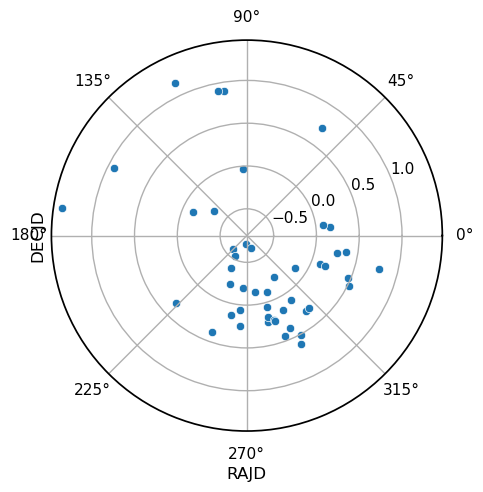

In [317]:
df_PTA = pd.read_pickle('../data/NANOGrav_pulsars')
g = sns.FacetGrid(df_PTA, subplot_kws=dict(projection='polar'),height=5, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='RAJD', y='DECJD')

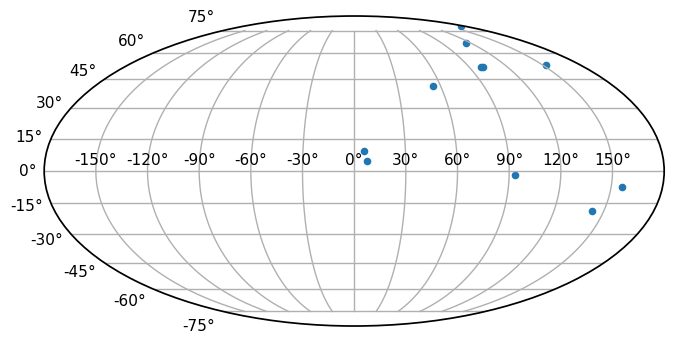

In [462]:

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")

ax.scatter(df_PTA["RAJD"],df_PTA["DECJD"],s=20)

ax.grid(True)

        # if savepath is not None:
        #     plt.savefig(savepath,dpi=300,bbox_inches='tight')

        # plt.show()

In [463]:
df_PTA["RAJD"]

6       0.101584
36      0.132894
144     0.961625
283     1.630717
309     1.728229
314     1.771442
350     2.010459
450     2.492848
490     2.672785
514     2.725526
603     2.993229
933     3.899772
936     3.908663
1115    4.192565
1168    4.252532
1295    4.364541
1310    4.379188
1475    4.510915
1612    4.620320
1638    4.631751
1663    4.644714
1694    4.659209
2116    4.854022
2401    4.947813
2457    4.963745
2536    4.987700
2650    5.016908
2664    5.018527
2686    5.026199
2767    5.056221
2806    5.076180
2932    5.147162
2958    5.166853
2974    5.176729
3028    5.216198
3081    5.282960
3091    5.311815
3130    5.381978
3145    5.425129
3234    5.697806
3261    5.823498
3275    5.889823
3278    5.909617
3279    5.911347
3299    6.033529
3311    6.096234
3315    6.119003
Name: RAJD, dtype: float64

In [464]:
df_PTA["DECJD"]

6       0.163886
36      0.084841
144     0.724531
283    -0.035136
309     0.898554
314     0.907062
350     1.157898
450    -0.332461
490     0.927072
514    -0.127795
603     1.367120
933     0.332253
936    -0.584910
1115   -0.539255
1168   -0.392851
1295    0.390997
1310   -0.216705
1475    0.136026
1612    0.062012
1638    0.241942
1663   -0.202142
1694   -0.708869
2116   -0.150365
2401    0.227979
2457    0.169671
2536    0.060307
2650   -0.658642
2664    0.225853
2686    0.240731
2767   -0.117106
2806    0.440892
2932    0.376696
2958    0.159228
2974    0.598428
3028    0.508683
3081   -0.233855
3091    0.105619
3130    0.306880
3145    0.300046
3234   -0.136807
3261    0.523784
3275    0.466573
3278    0.108059
3279    0.170025
3299    0.780269
3311    0.255842
3315    0.365659
Name: DECJD, dtype: float64

---


## 2. Creating synthetic data

We have our PTA, we now need to generate some data. Here "data" refers to the frequency timeseries of each pulsar $f(t)$ measured by an observer on Earth, which has been modulated by some distant GW. 

All the pulsar parameters have already been set. For this notebook we take the following parameters for the GW:

* $\omega$ = $1\times 10^{-8}$ (angular frequency of the wave)
* $\Phi_0$ = 0.20 (phase shift)
* $\psi$ = 2.5 (polarisation angle)
* $\iota$ = 0 (source inclination angle)
* RA = 1
* DEC = 0


We leave the GW strain amplitude $h$ as a free parameter that we will vary.

We will make observations over 10 years at a weekly cadence.


All parameters for this notebook are specified in `config.py : notebook`




### 2.1 How the data is generated 


The synthetic data is generated using a similar framework to the state-space structure from Melatos 2022 (private communication to UniMelb EE/GW group), with some small changes.


Firstly we evolve the intrinsic pulsar frequencies $f_p$ by solving the ODE

$$ \dot{f}_p = -\gamma f_p^n + \xi$$

where  $\xi$ is some stochastic white noise. 


Given the evolution of the state variables, the measured frequencies are


$$ f_m(t) = f_p(t)(1-X(t)) + N_f$$

for some function $g(\phi)$ which is specified on PT16 of Melatos 2022 and is implicitly a function of the GW parameters listed above. $N_f$ is the Gaussian measurement noise 

### 2.2 Noise magnitudes

Choosing the magnitudes of the process and measurement noises is currently quite uncertain.

For reference note that for PSR J1713+0747:

* $\delta f_m$ due to spindown is $\sim \dot{f} \cdot 10 \text{ years} \sim 30$ nHz 

* $\delta f_m$ due to GW is $\sim f \cdot h \sim 2 \times 10^{-5}$ nHz if $|h| \sim 10^{-16}$



We take the process noise to be $\sigma_p \sim 10^{-12}$ and the measurement noise to be $\sigma_m \sim 10^{-13}$. The choice of these parameters seems reasonable, but requires some more thought.




### 2.3 Generate the data


The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 1e-16
The Number format of the observations is: float128
The change in state frequency was: 1.2447775024626572815e-07
The change in measured frequency was: 1.2447737991749807662e-07


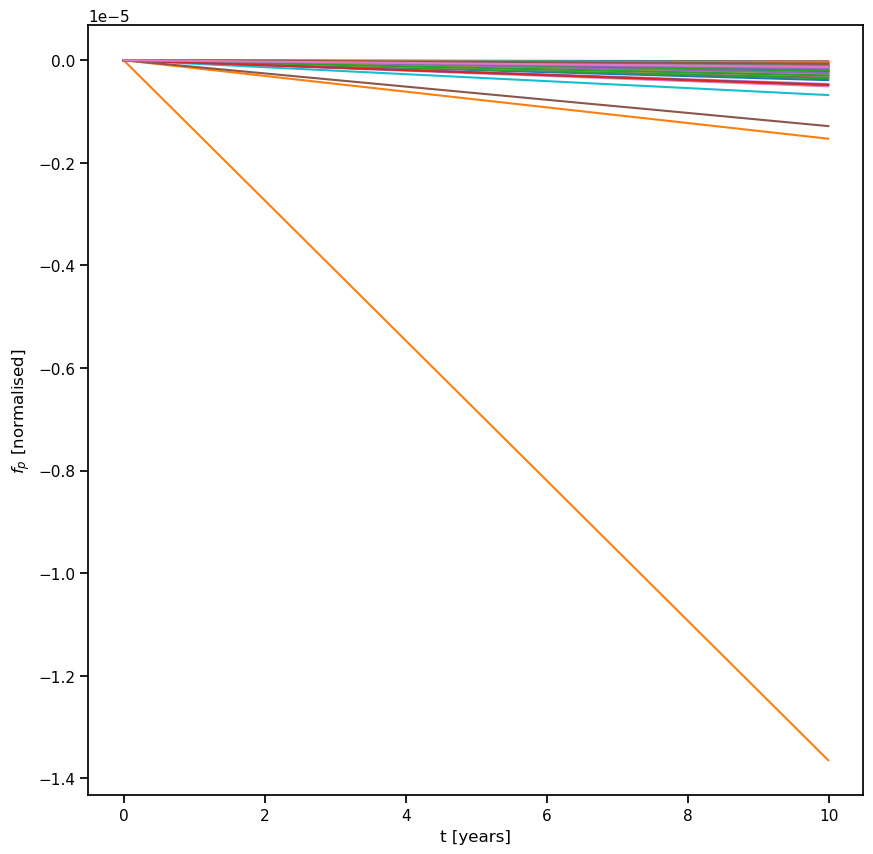

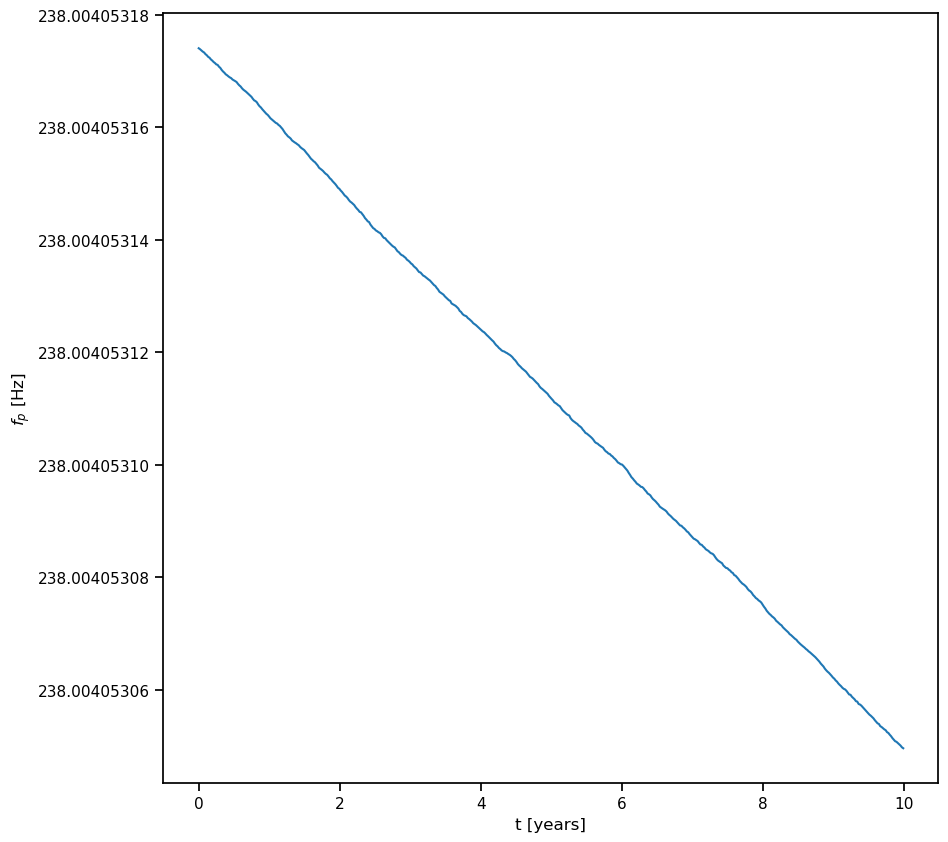

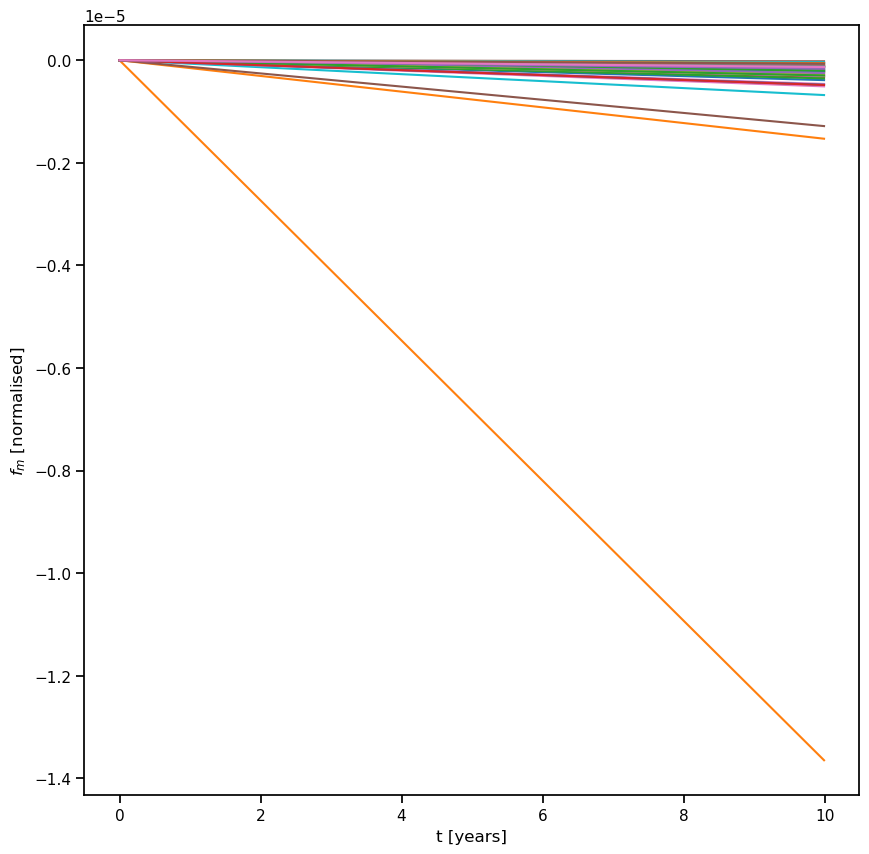

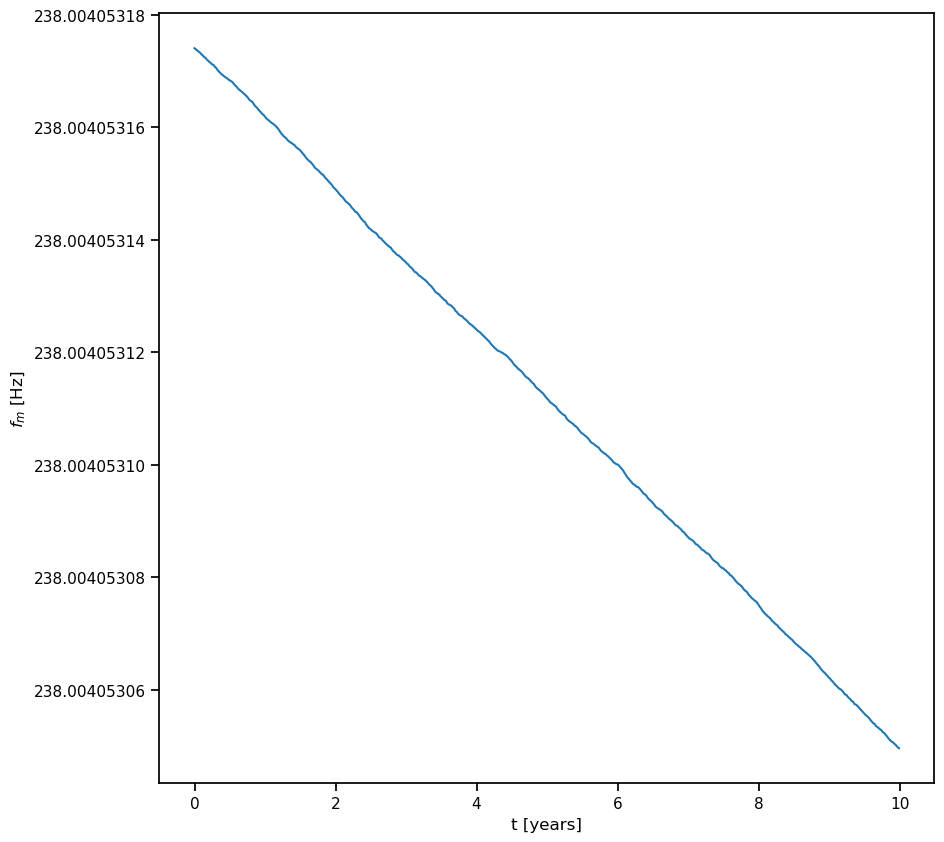

In [355]:
from configs.config import notebook as cfg
from configs.config import NF
from create_synthetic_data import PulsarFrequencyObservations


#First, let's create some synthetic data.
dt   = cfg["timing_parameters"]["dt_days"] 
Tend = cfg["timing_parameters"]["T_years"]     
t    = np.arange(0.0,Tend*365*24*3600,dt*24*3600,dtype=NF) #time runs from 0 to Tend, with intervals dt 

observations = PulsarFrequencyObservations(t)              # initialise the class, all observations have same times
observations.create_observations(cfg["pulsar_parameters"],
                                 cfg["GW_parameters"],
                                 cfg["noise_parameters"]) 



observations.plot_state_frequency(psr_index=None)    #Plot a single pulsar 
observations.plot_state_frequency(psr_index=10)

observations.plot_measurement_frequency(psr_index=None)    #Plot a single pulsar 
observations.plot_measurement_frequency(psr_index=10)

The pulsar with the large change in frequency is drop off is J1939+2134 (index 31)	which has an $\dot{f} \sim 10^{-14}$.




Since the GW strain is small, it is not obvious to the eye the effect of the GW on the frequency. IF we crank up the strain:

The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 1e-08
The Number format of the observations is: float128
The change in measured frequency was: 1.538250963495357837e-06


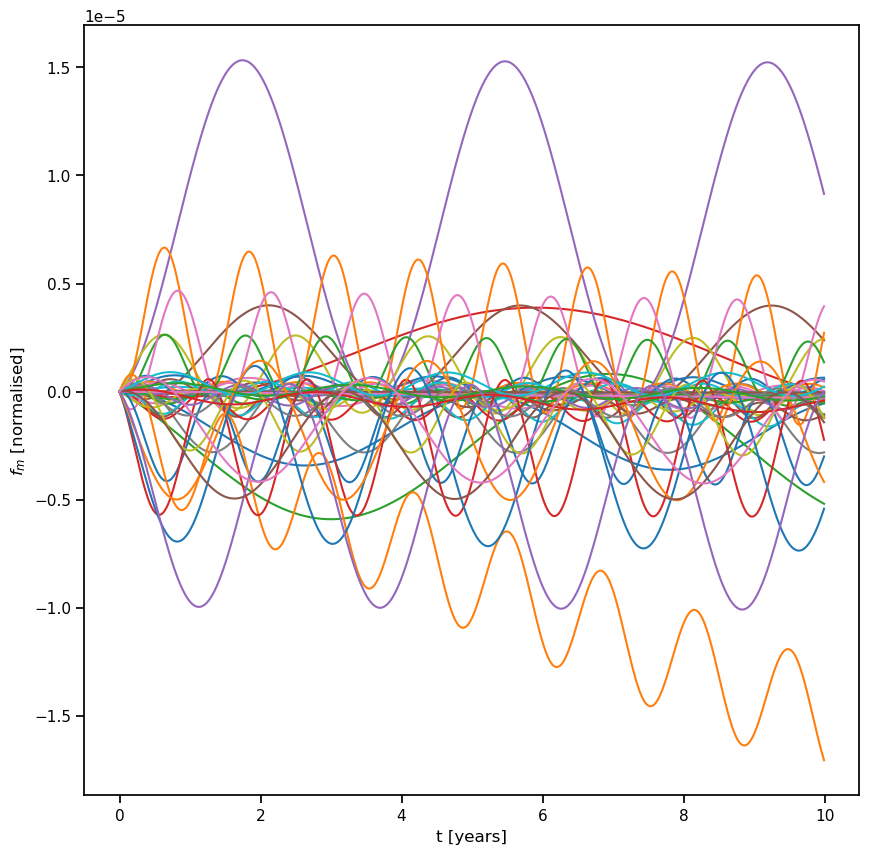

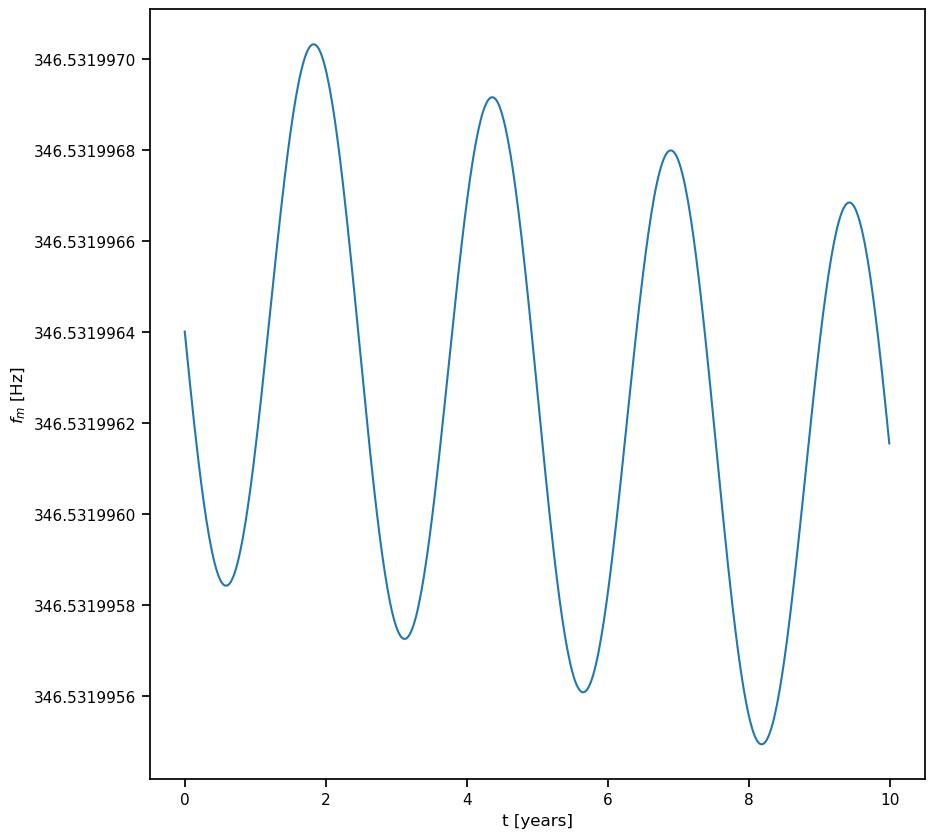

In [357]:
high_strain_observations = PulsarFrequencyObservations(t)              # re-initialise the class, 

GW_parameters =  cfg["GW_parameters"]
GW_parameters["h0"] = 1e-8       # override the strain
GW_parameters["omega_GW"] = 1e-7 # and the frequency

high_strain_observations.create_observations(cfg["pulsar_parameters"],
                                             GW_parameters,
                                             cfg["noise_parameters"]) 


high_strain_observations.plot_measurement_frequency(psr_index=None) #Plot all the pulsars
high_strain_observations.plot_measurement_frequency(psr_index=6)    #Plot a single pulsar 

---


## 3. Model selection using a UKF
Given the synthetic data we can now try to use our UKF to try to find evidence of the GW signal in this data.

We have two models:


1. **Null model** $M_0$. There is no GW in the data. In this case the measurement model of the UKF simply returns the frequency states (i.e. $g(\phi) = 0$)

2. **Alternative model** $M_1$. There _is_ a GW in the data. The measurement model uses the full expression for $g(\phi)$



In order to accept the alternative hypothesis $M_1$ over $M_0$ there are two approaches we could take:


* The first is a fully Bayesian search over all the parameters for each model, calculating the evidence for each model and then determining the Bayes ratio. This is perhaps the most consistent way, but it is obviously expensive and at this stage we are keen to explore how detectability varies with e.g. GW strain.

* The second method is to recognize that $M_0$ and $M_1$ are hierarchically nested models and we can perform a likelihood ratio test. That is, given the maximum likelihood estimators $\hat{\theta}$ of the true parameters $\theta$, the likelihood of each model can be calculated and compared. These likelihoods are just  point estimates of the Bayes factor numerator/denominators.


Given the cheap cost we proceed with the second method.


## 3.1 Likelihood ratio test


For the likelihood ratio test we do not perform any kind of maximum likelihood search over the parameters for each of the models. Instead we just set the $\hat{\theta} = \theta$ i.e. artificially set the maximum likelihood estimators to be equal to the true parameters of the system. We assume that any ML algorithm would converge to these parameters - this could be an oversimplification but it serves our purposes for now.


Interpreting the likelihood ratio also needs some consideration, since we have to account for the increased model complexity of $M_1$ (not needed for Bayes factors!). This can be accomplished via [Wilks' Theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem) which states that (for a [large number of samples](https://www.osti.gov/servlets/purl/1529145)) the distribution of the test statistic approaches the chi-squared distribution under the null hypothesis i.e. 

$$ 2 \log \Lambda \rightarrow \chi^2$$




One can then compute $p$-values where the number of degrees of freedom is equal to the difference in the number of parameters of the two models.  $M_1$ has 7 extra parameters over $M_0$.

In [474]:
from scipy.stats.distributions import chi2
chi2.sf(18.5,7)  #chi2.sf(statistic,dof)

0.009906662270093614

In [475]:
chi2.sf(14,7)  #chi2.sf(statistic,dof)

0.051181353413065414

Therefore $D = -2 \log \lambda = 14$ corresponds to a 5% chance that the result occurred under the null hypothesis.

Now lets see how this works in practice:

In [387]:
from UKF import UnscentedKalmanFilter
from model import MelatosPTAModel

    
    
  

#Initialise the state-space model to be used with the UKF
#We pass the model class a dictionary of known quantities that any parameter estimation algo would NOT search over
dictionary_of_known_quantities = {"pulsar_directions": observations.q,                              # we know the pulsar directions
                                  "pulsar_distances":  observations.pulsar_distances,               # for now lets say we also know their distances. In reality we have some constrained prior
                                  "measurement_noise": cfg["noise_parameters"]["measurement_noise"], # and we know the measurement noise of our detector?
                                }
model = MelatosPTAModel(observations.Npulsars + 1,
                        observations.Npulsars,
                        dictionary_of_known_quantities)



#Now initialise the UKF
KF = UnscentedKalmanFilter(
                        observations=observations,
                        model = model,
                        UKF_settings=cfg["UKF_parameters"]
                        )

# Then run it for a particular set of parameters.
# We provide here the actual parameters used to generate the synthetic data
#...under the assumption that any ML algo would find similar values
parameters = {"omega":   observations.omega_GW,
            "gamma":     observations.spindown_gamma[0],
            "n":         observations.spindown_n[0],
            "dec_gw":    cfg["GW_parameters"]["dec_GW"],
            "ra_gw":     cfg["GW_parameters"]["ra_GW"],
            "psi_gw":    cfg["GW_parameters"]["psi_GW"],
            "Agw":       observations.Agw,
            "iota_gw":   cfg["GW_parameters"]["iota"],
            "phi0":      cfg["GW_parameters"]["phase_normalisation"]
            }


#This is the likelihood of the alternative hypothesis
model_likelihood = KF.ll_on_data(parameters,"alternative")
model_predictions = KF.state_array
print("model likelihood=",model_likelihood)

#This is the likelihood of the null hypothesis
null_likelihood = KF.ll_on_data(parameters,"null")
null_predictions = KF.state_array
print("null likelihood=",null_likelihood)

#and the test statistic
test_statistic = 2 * (model_likelihood - null_likelihood)




print(f"Test_statistic is {test_statistic} compared to a target of 14 at a 5% tolerance")


model likelihood= 400372.88682110428906
null likelihood= 400372.75832326859566
Test_statistic is 0.2569956713867896 compared to a target of 14 at a 5% tolerance


The mean error in the state prediction is: 6.5442463559754073545e-10
Difference in the state frequency: 3.228970383850615633e-07
Difference in the observed frequency: 2.0453848703638755069e-07


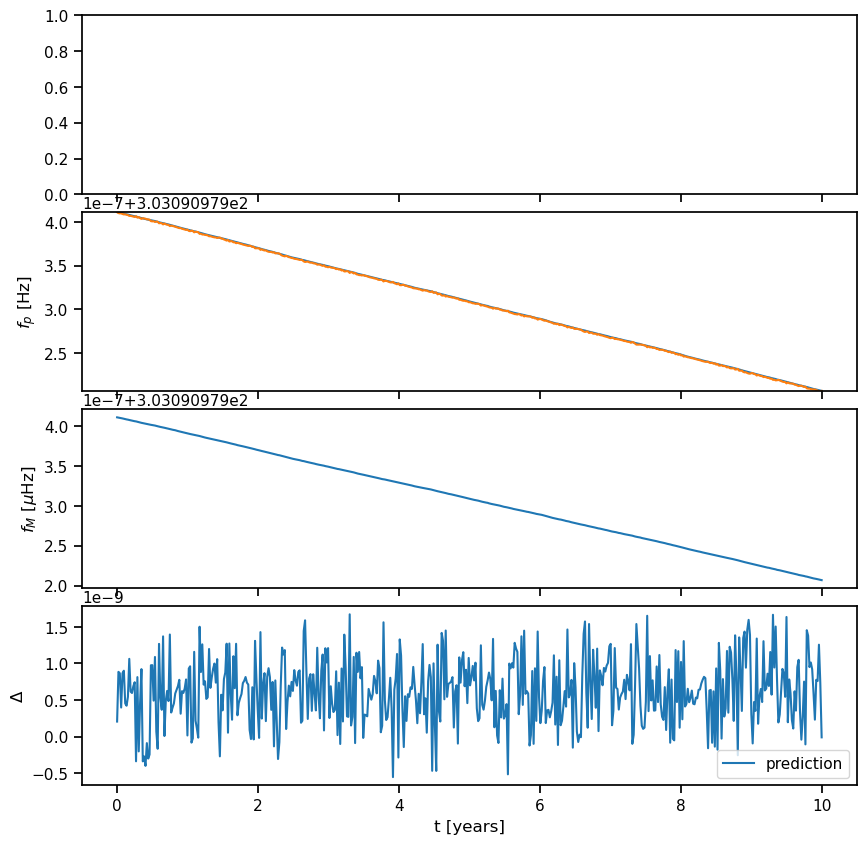

Great! So for this particular system (and this particular instance of the noise) we can say that $M_1$ is preferred and there is evidence for a GW in our data.



---


## 4. How does the SNR vary with the system parameters?


The test statistic above is just for one particular system realisation. It is of interest to see how this varies with different system parameters. Lets first package up all the above steps into a single function:


In [713]:
from UKF import UnscentedKalmanFilter
from create_synthetic_data import PulsarFrequencyObservations
from model import MelatosPTAModel

from configs.config import canonical as notebook
from configs.config import NF



def go(overriding_parameters,seed):

    if isinstance(seed,int):
        np.random.seed(seed)


    #First, let's create some synthetic data.
    dt   = cfg["timing_parameters"]["dt_days"] 
    Tend = cfg["timing_parameters"]["T_years"]     
    t    = np.arange(0.0,Tend*365*24*3600,dt*24*3600,dtype=NF) #time runs from 0 to Tend, with intervals dt 



    pulsar_parameters = cfg["pulsar_parameters"]
    GW_parameters     = cfg["GW_parameters"]
    noise_parameters  = cfg["noise_parameters"]


    #Bit verbose - not very Pythonic
    for d in [pulsar_parameters,GW_parameters,noise_parameters]:
        k = d.keys()
        for x in overriding_parameters:
            if x in k:         
                d[x] = NF(overriding_parameters[x]) #override the value in the cfg
                print("Overriding default parameters:", x,overriding_parameters[x])







    observations = PulsarFrequencyObservations(t)              # initialise the class, all observations have same times
    observations.create_observations(pulsar_parameters,
                                    GW_parameters,
                                    noise_parameters)  # generate the observations. You can also plot this as e.g. observations.plot_observations(psr_index=2,KF_predictions = None) 



    
    #Initialise the state-space model to be used with the UKF
    #We pass the model class a dictionary of known quantities that any parameter estimation algo would NOT search over
    dictionary_of_known_quantities = {"pulsar_directions": observations.q,                              # we know the pulsar directions
                                      "pulsar_distances":  observations.pulsar_distances,               # for now lets say we also know their distances. In reality we have some constrained prior
                                      "measurement_noise": cfg["noise_parameters"]["measurement_noise"], # and we know the measurement noise of our detector?
                                    }
    model = MelatosPTAModel(observations.Npulsars,
                            observations.Npulsars,
                            dictionary_of_known_quantities)




    #Now let's run the UKF on this data

    #First initialise the KF
    KF = UnscentedKalmanFilter(
                            observations=observations,
                            model = model,
                            UKF_settings=cfg["UKF_parameters"]
                            )

      # Then run it for a particular set of parameters.
      # We provide here the actual parameters used to generate the synthetic data
      #...under the assumption that any ML algo would find similar values
    parameters = {"omega":   observations.omega_GW,
                  "gamma":     observations.spindown_gamma[0],
                  "n":         observations.spindown_n[0],
                  "dec_gw":    GW_parameters["dec_GW"],
                  "ra_gw":     GW_parameters["ra_GW"],
                  "psi_gw":    GW_parameters["psi_GW"],
                  "Agw":       observations.Agw,
                  "iota_gw":   GW_parameters["iota"],
                  "phi0":      GW_parameters["phase_normalisation"]
                  }




    model_likelihood = KF.ll_on_data(parameters,"1.0")
    model_predictions = KF.state_array

    print("model likelihood = ", model_likelihood)



    null_likelihood = KF.ll_on_data(parameters,"null")
    null_predictions = KF.state_array

    print ("null likelihood = ", null_likelihood)
    

    test_statistic = 2 * (model_likelihood - null_likelihood)




    print(f"Test_statistic is {test_statistic} compared to a target of 14 at a 5% tolerance")


    return test_statistic,model_predictions,null_predictions,observations
  

In [714]:
seed = 10033
override_parameters = {"h0": 2e-8}
TS,model_predictions,null_predictions,observations = go(override_parameters,seed)

Overriding default parameters: h0 2e-08
The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 2e-08
The angular frequency of the GW is 1e-07
The Number format of the observations is: float128
The value of self.R is 1.0000000000000000385e-26
initial time 0.0
model likelihood =  416736.91944135829513
The value of self.R is 1.0000000000000000385e-26
initial time 0.0
null likelihood =  -1079286.1403477973805
Test_statistic is 2992046.119578311 compared to a target of 14 at a 5% tolerance


The mean error in the state prediction is: 3.0593492914010589345e-07
Difference in the state frequency: 3.1620189999692627225e-07
Difference in the observed frequency: 1.3535974146050566702e-05


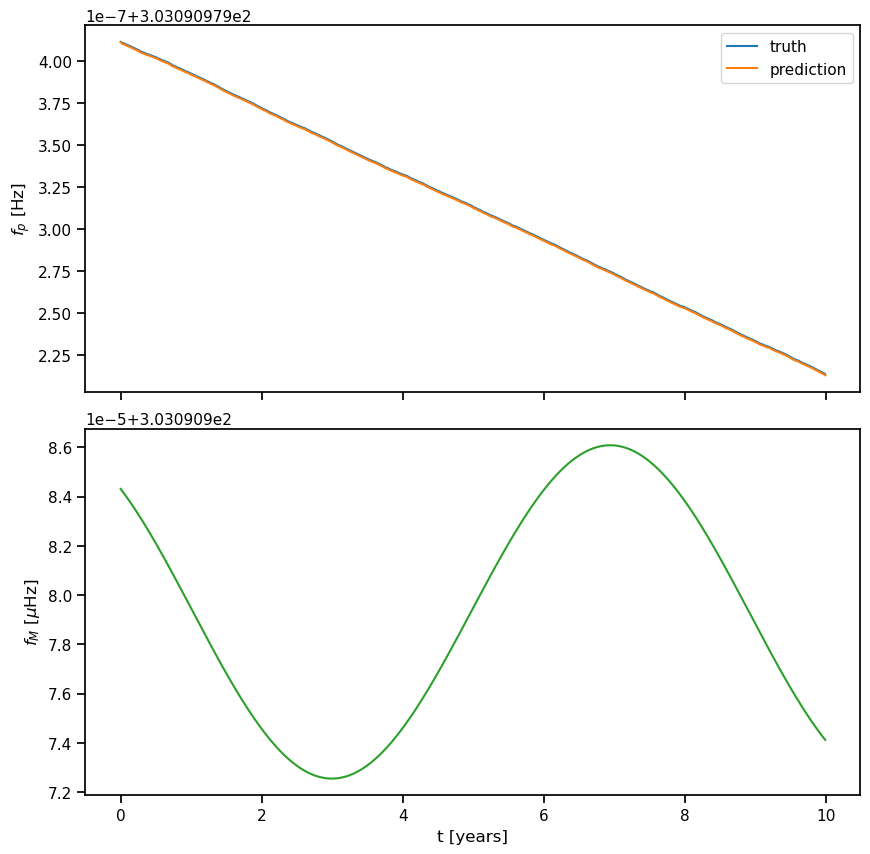

In [701]:
#observations.plot_observations(psr_index=2,KF_predictions = model_predictions,savefig='../data/model.png')
observations.plot_observations(psr_index=2,KF_predictions = model_predictions,savefig=None)



The mean error in the state prediction is: 0.0020806062298040217673
Difference in the state frequency: 3.1620189999692627225e-07
Difference in the observed frequency: 1.3535974146050566702e-05


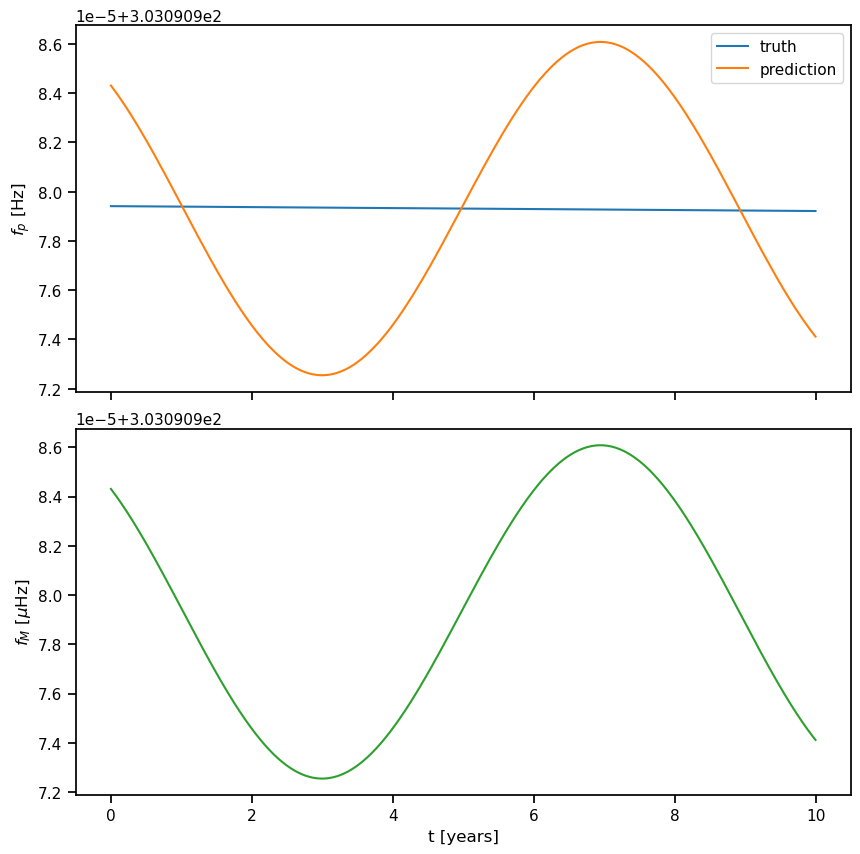

In [702]:
#observations.plot_observations(psr_index=2,KF_predictions = null_predictions,savefig='../data/null.png') #Can plot this
observations.plot_observations(psr_index=2,KF_predictions = null_predictions,savefig=None) #Can plot this


Note that we can now also passing an RNG seed to ensure reproducibility between runs.

Lets explore how the SNR varies with GW strain $h$, _for a specific realisation of the noise_

In [711]:
# %%capture 
#

seed = 10033
i = 0
xx = np.arange(-12,-8)
parameter_space = np.zeros(len(xx))
for h in xx:
        override_parameters = {"h0": 2*10**float(h)}
        TS,model_predictions,null_predictions,observations = go(override_parameters,seed)
        parameter_space[i] = TS
        i += 1
        print('-----------------------')

Overriding default parameters: h0 2e-12
The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 2e-12
The angular frequency of the GW is 1e-07
The Number format of the observations is: float128
The value of self.R is 1.0000000000000000385e-26
initial time 0.0
model likelihood =  416290.73541109204527
The value of self.R is 1.0000000000000000385e-26
initial time 0.0
null likelihood =  416290.78334633009783
Test_statistic is -0.09587047610511945 compared to a target of 14 at a 5% tolerance
-----------------------
Overriding default parameters: h0 2e-11
The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 2e-11
The angular frequency of the GW is 1e-07
The Number format of the observations is: float128
The value of self.R is 1.0000000000000000385e-26
initial time 0.0
model likelihood =  416291.1158671976063
The value of self.R is 1.0000000000000000385e-26
ini

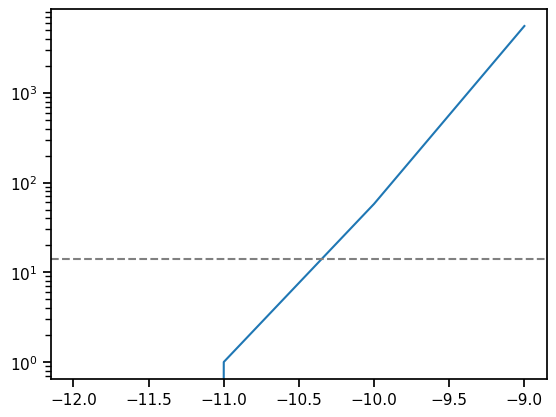

In [708]:
plt.plot(xx, parameter_space)
plt.yscale('log')
plt.axhline(14,c='0.5', linestyle='--')
#plt.xlim(1e-18,1e-15)

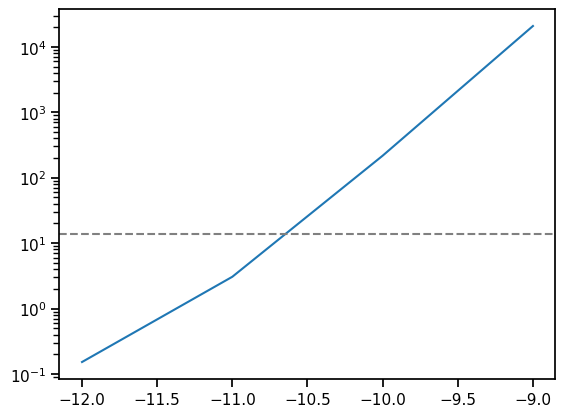

In [710]:
plt.plot(xx, parameter_space)
plt.yscale('log')
plt.axhline(14,c='0.5', linestyle='--')
#plt.xlim(1e-18,1e-15)

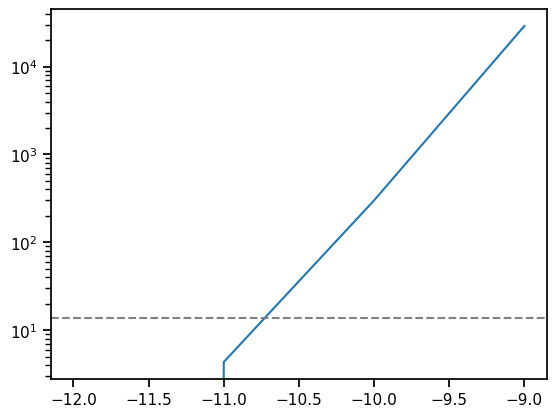

In [712]:
plt.plot(xx, parameter_space)
plt.yscale('log')
plt.axhline(14,c='0.5', linestyle='--')
#plt.xlim(1e-18,1e-15)

In [278]:
%%capture 
#

seed = 1432
i = 0
xx = np.arange(-18,-8)
parameter_space = np.zeros(len(xx))
for h in xx:
        override_parameters = {"h0": 10**float(h)}
        TS = go(override_parameters,seed)
        parameter_space[i] = TS
        i += 1

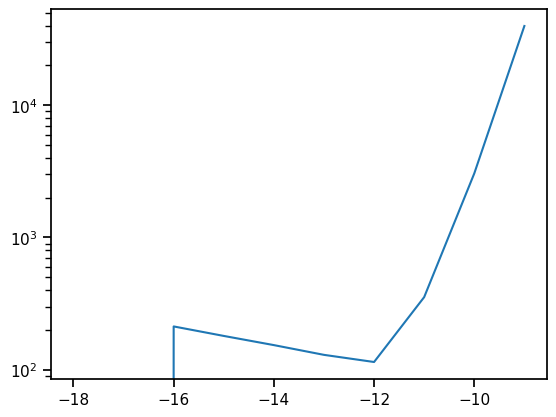

In [280]:
plt.plot(xx, parameter_space)
plt.yscale('log')
#plt.xlim(1e-18,1e-15)

---

# Appendix

## A1. Caveats 

(I'm sure there are more than listed here...)


* We have asssumed that all pulsars have $n=3$. What about some distribution?

* We have only considered a single GW source at a particualr location, polarisation, etc. What about others?

* We have focused only on a monochromatic GW source. This is probably not a bad approximation, but maybe we can include some process noise on the phase evolution too?

* We assume all pulsars have observations taken at the same time

* How reasonable are our noises? For instance, what is a reasonable measurement noise on the frequency evolution of a MSP?

* What about doing a full Bayesian search using e.g. Bilby to get a Bayes ratio?

* How good/bad an assumption is it that $\hat{\theta} \sim \theta$ for our likelihood ratio test?